In [23]:
import os

In [1]:
import torch

In [2]:
torch.__version__

'1.12.1'

In [3]:
import cudatoolkit 

ModuleNotFoundError: No module named 'cudatoolkit'

In [1]:
# !CUDA_LAUNCH_BLOCKING=1

In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
import sys
sys.path.append("..")


In [2]:
import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch.multiprocessing as mp
mp.set_start_method('spawn')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from src.utils import project_root, AverageMeter
from src.data.rulibrispeech import ruLibriSpeechDataset, TextEncoder, Collator, Featurizer
from src.data.utils import ru_alphabet
from src.metrics.metrics import WordErrorRate

In [3]:
import gc
from matplotlib import pyplot as plt

In [4]:
sample_rate=16000
n_mels=80

In [5]:
data_path = project_root() / "data/ruLibriSpeech/ruls_data"
train_dataset = ruLibriSpeechDataset(data_path, "train", sample_rate=sample_rate)
validation_dataset = ruLibriSpeechDataset(data_path, "test", sample_rate=sample_rate)


encoder = TextEncoder(ru_alphabet)
collator = Collator(encoder)


batch_size = 2

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, collate_fn=collator,
    num_workers=1, pin_memory=False
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size,
    collate_fn=collator,
    num_workers=1, pin_memory=False
)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [6]:
print("train_dataset", len(train_dataset))
print("validation_dataset", len(validation_dataset))

train_dataset 54472
validation_dataset 1352


In [7]:
featurizer = Featurizer(n_mels=n_mels, sample_rate=sample_rate).to(device)

In [8]:
from src.model.squeezeformer.squeezeformer import Squeezeformer

In [9]:
numclasses = len(ru_alphabet)

model = Squeezeformer(
    num_classes=numclasses,
    input_dim=n_mels,
    encoder_dim=256
).to(device)

In [10]:
criterion = nn.CTCLoss().to(device)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.9995),  weight_decay=5e-6)

In [12]:
# for batch in train_dataloader:
#     break

In [13]:
# wav = batch['wav'].to(device)
# length = batch['length'].to(device)
# targets = batch['targets'].to(device)
# target_lengths = batch['target_lengths'].to(device)

# mel, mel_length = featurizer(wav, length)
# mel = torch.swapaxes(mel, 1, 2)

In [14]:
# outputs, output_lengths = model(mel, mel_length)

In [15]:
# loss = criterion(outputs.transpose(0, 1), targets, output_lengths, target_lengths)

In [16]:
# optimizer.zero_grad()

In [17]:
# loss.backward()

In [18]:
# loss

In [19]:
# optimizer.step()

In [20]:
def save_model(ckpt_path, model, optimizer, epoch, batch_index):
    ckpt = {
        "model": model.state_dict(), 
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "batch_index": batch_index
    }
    ckpt_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(ckpt, ckpt_path)
    
def load_model(ckpt_path):
    return torch.load(ckpt_path, map_location=torch.device("cpu"))

In [21]:
ckpt_path = project_root()/"ckpt/squeezeformer/ckpt.pt"


In [24]:
if os.path.exists(ckpt_path):
    ckpt = load_model(ckpt_path)
    print("epoch", ckpt['epoch'], "batch_index", ckpt['batch_index'])
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    print("model and optimizer loaded")

epoch 0 batch_index 700
model and optimizer loaded


In [24]:
storage = defaultdict(list)
num_epoch = 4

for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(pbar := tqdm(train_dataloader)):
        gc.collect()
        optimizer.zero_grad()
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        targets = batch['targets'].to(device)
        target_lengths = batch['target_lengths'].to(device)

        mel, mel_length = featurizer(wav, length)
        mel = torch.swapaxes(mel, 1, 2).contiguous()
        
#         print("max mel", mel.max())
#         print("min mel", mel.min())
        
        outputs, output_lengths = model(mel, mel_length)
        
        loss = criterion(outputs.transpose(0, 1).contiguous(), targets, output_lengths, target_lengths)
        loss.backward()
        optimizer.step()
#         print("max grad", max(p.grad.max() for p in list(model.parameters())))
#         print("min grad", max(p.grad.min() for p in list(model.parameters())))
        pbar.set_description(f"loss: {loss.item():.5}")
        
        train_loss_meter.update(loss.item())
        
        if i % 10 == 0:
            save_model(ckpt_path, model, optimizer, epoch, i)
    storage['train_loss'].append(train_loss_meter.avg)

    validation_loss_meter = AverageMeter()
    validation_wer_meter = AverageMeter()

    model.eval()
    wer_metrics = WordErrorRate(encoder)
    for i, batch in enumerate(tqdm(islice(validation_dataloader, 1))):
        gc.collect()
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        targets = batch['targets'].to(device)
        target_lengths = batch['target_lengths'].to(device)

        with torch.no_grad():
            mel, mel_length = featurizer(wav, length)
            mel = torch.swapaxes(mel, 1, 2)
        
            outputs, output_lengths = model(mel, mel_length)
            loss = criterion(outputs.transpose(0, 1), targets, output_lengths, target_lengths)
            
            
        validation_loss_meter.update(loss.item())
        validation_wer_meter.update(wer_metrics(targets.cpu(),  outputs.argmax(dim=-1).cpu()))
    
        pbar.set_description(f"loss: {loss.item():.5}, wer: {validation_wer_meter.val}")

    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_wer'].append(validation_wer_meter.avg)


    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    axes[2].plot(storage['validation_wer'], label='validation_WER')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

  0%|          | 0/27236 [00:00<?, ?it/s]/home/user/grandeur/notebooks/../src/data/rulibrispeech.py:119: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  length = (length - self.featurizer.win_length) // self.featurizer.hop_length
loss: 2.4574:   1%|          | 144/27236 [01:24<4:24:17,  1.71it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [25]:
for batch in train_dataloader:
    break

In [26]:
wav = batch['wav'].to(device)
length = batch['length'].to(device)
targets = batch['targets'].to(device)
target_lengths = batch['target_lengths'].to(device)

mel, mel_length = featurizer(wav, length)
mel = torch.swapaxes(mel, 1, 2)

/home/user/grandeur/notebooks/../src/data/rulibrispeech.py:119: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  length = (length - self.featurizer.win_length) // self.featurizer.hop_length


In [33]:
wav = wav.cpu()

In [34]:
import torchaudio.transforms as T

In [111]:
mfcc = T.MFCC(sample_rate=16000, n_mfcc=80, log_mels = True)

In [112]:
mfcc_log = mfcc(wav)

In [113]:
mfcc_log.shape

torch.Size([2, 80, 805])

In [114]:
mfcc_log.min()

tensor(-156.3047)

In [115]:
torch.sum(mfcc_log < -10)

tensor(3178)

In [116]:
mfcc_log.shape

torch.Size([2, 80, 805])

In [128]:
wav.shape[-1] / mfcc_log.shape[-1]

199.9503105590062

torch.Size([2, 80, 805])

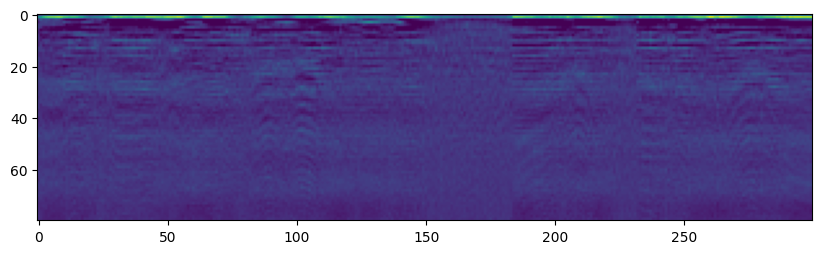

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(torch.clamp(mfcc_log[1], min=-10, max=60)[:, :300].numpy())

In [85]:
mel = torch.swapaxes(mel, 1, 2)

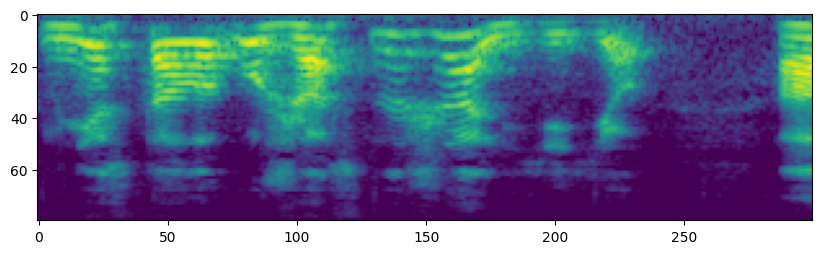

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(mel.cpu()[1][:, :300].numpy())

In [27]:
with torch.no_grad():

    outputs, output_lengths = model(mel, mel_length)

In [29]:
outputs

tensor([[[-2.7144, -3.1987, -3.9237,  ..., -6.1045, -3.4811, -8.7095],
         [-0.8319, -2.4625, -5.2812,  ..., -6.4183, -5.5865, -9.6042],
         [-0.5694, -2.8967, -5.4487,  ..., -6.4369, -5.8230, -9.7641],
         ...,
         [-1.7781, -2.5379, -5.4251,  ..., -2.8828, -3.3826, -7.6367],
         [-1.3325, -2.6080, -5.4927,  ..., -3.0913, -4.1251, -7.9480],
         [-1.7859, -2.5756, -5.4841,  ..., -2.6380, -3.4696, -7.7182]],

        [[-2.7505, -2.9612, -3.8119,  ..., -6.1804, -3.5490, -8.4680],
         [-0.9866, -2.3064, -5.1968,  ..., -6.1733, -5.6374, -9.4086],
         [-0.5688, -2.8168, -5.4127,  ..., -6.2044, -6.0979, -9.4899],
         ...,
         [-1.9348, -2.5383, -5.2249,  ..., -2.6130, -3.5608, -7.3919],
         [-0.9929, -2.5939, -5.3073,  ..., -3.7938, -4.0538, -8.7166],
         [-1.3915, -2.6738, -5.1810,  ..., -2.9538, -3.6225, -7.6114]]],
       device='cuda:0')

In [16]:
mel.cpu().shape

torch.Size([4, 2193, 80])

In [17]:
mel = torch.swapaxes(mel, 1, 2)

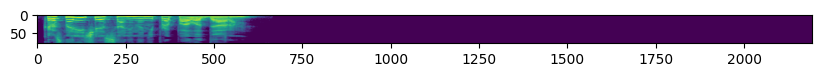

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(mel.cpu()[2].numpy())

In [22]:
encoder.decode(targets[0].cpu().numpy())

'возразил с сокрушеньем михалевич я к несчастью ничем не заслужил еще такого высокого наименования'

In [23]:
from IPython import display
display.Audio(wav[0].cpu().numpy(), rate=sample_rate)

In [37]:
wav[0]

tensor([-0.0194, -0.0190, -0.0189,  ..., -0.0120, -0.0096, -0.0080],
       device='cuda:0')

In [24]:
mel.min()

tensor(-11.5129, device='cuda:0')

In [ ]:
x = torch.tensor(5)

In [ ]:
ru_alphabet.inverse[int(x)]

In [ ]:
##########

In [22]:
wav[0].shape[0] / 16000

7.92

In [ ]:
16000